In [25]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from tqdm import tqdm, tqdm_notebook
from sklearn import preprocessing
import talib

sys.path.append('../Runs')
from train_QTable import optimal_strategy, run
from train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples
from helper.Q_learning import round_custombase
from helper.manage_orderbooks import OrderbookEpisodesGenerator, plot_episode
from helper.orderbook_trader import OrderbookTradingSimulator
from agents.QTable_Agent import QTable_Agent
from agents.BatchTree_Agent import RLAgent_BatchTree


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
samplefiles = [
    # '../Runs/experiments/test20/test20.csv'
    #'../Runs/experiments/3Month_USDTBTC_Qtable_100vol10_60T4_Nov/3Month_USDTBTC_Qtable_100vol10_60T4_Nov.csv',
    #'../Runs/experiments/3Month_USDTBTC_Qtable_100vol10_60T4_Dez/3Month_USDTBTC_Qtable_100vol10_60T4_Dez.csv',
    #'../Runs/experiments/3Month_USDTBTC_Qtable_100vol10_60T4_Jan/3Month_USDTBTC_Qtable_100vol10_60T4_Jan.csv',
    # '../Runs/experiments/3Month_USDTBTC_Qtable_100vol10_60T4_Feb/3Month_USDTBTC_Qtable_100vol10_60T4_Feb.csv',
    #'../Runs/experiments_baselineMarket/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.csv',
    #'../Runs/experiments_baselineMarket/USDTBTC_Qtable_100vol10_60T4_Dez/USDTBTC_Qtable_100vol10_60T4_Dez.csv',
    #'../Runs/experiments_baselineMarket/USDTBTC_Qtable_100vol10_60T4_Jan/USDTBTC_Qtable_100vol10_60T4_Jan.csv',
    '../Runs/experiments_baselineMarket_costsFixed/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.csv',
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in samplefiles])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time'] = df['time'].astype(int)
df['time_n'] = df['time_n'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251565 entries, 0 to 251564
Data columns (total 10 columns):
volume            251565 non-null float64
time              251565 non-null int64
action            251565 non-null float64
action_idx        251565 non-null int64
cost              251565 non-null float64
avg               251565 non-null float64
initial_center    251565 non-null float64
timestamp         251565 non-null datetime64[ns]
volume_n          251565 non-null float64
time_n            251565 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 21.1 MB


In [22]:
volume=100
volume_intervals=10
decision_points=4
period_length=15
# action_min=-0.4
# action_max=1.0
# action_count=15
# actions = list(np.linspace(action_min, action_max, num=action_count))
# actions = [round(a, 1) for a in actions]

state_variables=['volume','time', 'future15_disc']

actions = range(-4,11)

### Prepare QTable_Agent

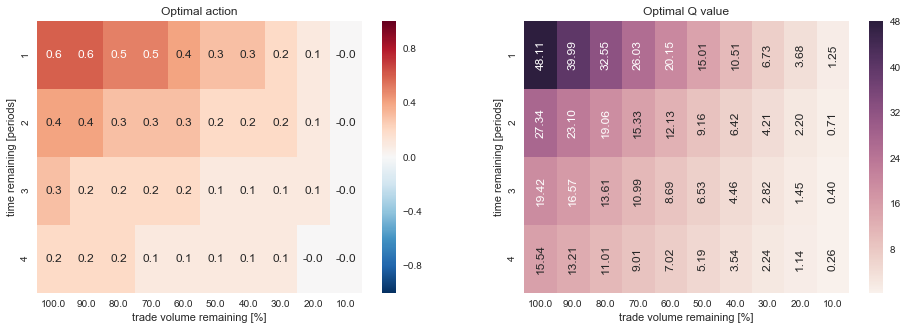

In [6]:
# load pretrained QTable_Agent
agent_Q = QTable_Agent.load(infile_agent='../Runs/experiments_baselineMarket/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.json',
                          infile_samples="../Runs/experiments_baselineMarket/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.csv")
# retrain QTable_Agent from samples
# agent_Q = train_Qtable_fromSamples(
#     samples=df, V=volume, T=decision_points, period_length=period_length,
#     vol_intervals=volume_intervals, actions=actions, state_variables=state_variables
# )

agent_Q.heatmap_Q(show_traces=False)

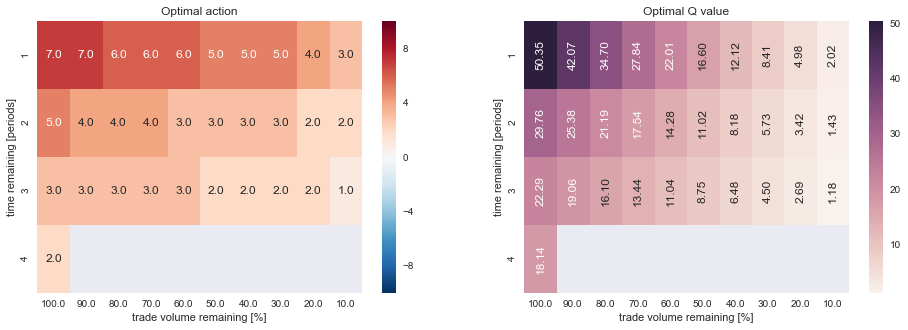

In [7]:
# load pretrained QTable_Agent
agent_Q = QTable_Agent.load(infile_agent='../Runs/experiments_baselineMarket_costsFixed/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.json',
                          infile_samples="../Runs/experiments_baselineMarket_costsFixed/USDTBTC_Qtable_100vol10_60T4_Nov/USDTBTC_Qtable_100vol10_60T4_Nov.csv")
# retrain QTable_Agent from samples
# agent_Q = train_Qtable_fromSamples(
#     samples=df, V=volume, T=decision_points, period_length=period_length,
#     vol_intervals=volume_intervals, actions=actions, state_variables=state_variables
# )

agent_Q.heatmap_Q(show_traces=False)

### Load Orderbooks

In [8]:
data_nov = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
print(data_nov[0][0].timestamp)
print(len(data_nov))

2016-11-08T10:00
20


In [9]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print(data_feb[0][0].timestamp)
print(len(data_feb))

2017-02-01T00:00
670


### Prepare Market Feature History

In [10]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    #market_features = hist.loc[ts_prev:ts, :]

    # for timeperiod in [10, 60]:
    #     featurename = "EMA{}".format(timeperiod)
    #     hist[featurename] = talib.EMA(
    #                                 np.array(hist['last']),
    #                                 timeperiod=timeperiod
    #                                 ) / hist['last']
    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2016-12_USDT_BTC.csv",
    "../../../../data/history/history_2017-01_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv"
]

hist = load_and_preprocess_historyfiles(files=histfiles)
display(hist.describe())
display(hist.head())

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45
count,1.621200e+05,162120.000000,162120.000000,162120.000000,162120.000000,162120.000000,162120.000000,162120.000000,1.621200e+05,1.621050e+05,162090.000000,162075.000000
mean,1.276362e+06,901.008831,885.727878,886.531529,863.952895,887.264855,0.005197,1360.507253,1.536977e+00,5.594804e-05,0.000110,0.000164
std,1.538277e+06,138.060815,133.130959,133.273092,124.956067,133.305641,0.031842,1573.762217,1.187912e+00,3.788001e-03,0.004993,0.005953
min,7.800989e+04,705.947000,685.000000,685.000000,681.722800,685.010000,-0.208371,101.758309,9.999894e-09,-1.104571e-01,-0.139130,-0.169927
25%,3.203091e+05,772.963000,765.000000,765.568523,752.010200,766.498407,-0.004401,408.384614,5.999999e-01,-1.351351e-03,-0.001674,-0.001882
50%,8.562623e+05,912.000000,894.000000,894.664000,852.287193,895.195000,0.005510,929.744540,1.368758e+00,1.293654e-11,0.000020,0.000112
75%,1.541231e+06,1009.999999,994.127466,995.000001,957.020000,996.000000,0.018515,1604.377153,2.271645e+00,1.652263e-03,0.002097,0.002438
max,1.021015e+07,1225.000000,1221.000000,1225.000000,1178.110000,1225.000000,0.139923,10660.050620,3.267844e+01,1.015637e-01,0.066240,0.070998


,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45
2016-11-08 10:00:00,320952.905870,710.663067,705.000000,705.450997,698.910282,705.450997,-0.003688,454.600078,0.450997,-3.246150e-08,-0.000639,-0.002576
2016-11-08 10:01:00,320952.905870,710.663067,703.800788,705.000000,698.910282,705.450997,-0.003094,454.600078,1.650209,6.396770e-04,0.000640,-0.001938
2016-11-08 10:02:00,320968.937789,710.663067,703.800788,705.000000,698.910282,705.450995,-0.003094,454.622819,1.650208,6.396770e-04,0.000640,0.001685
2016-11-08 10:03:00,320968.937789,710.663067,703.800788,705.450995,698.910282,705.450994,-0.002457,454.622819,1.650206,-3.168186e-08,-0.002057,0.001045
2016-11-08 10:04:00,321063.814154,710.663067,703.800788,703.800788,698.910282,705.450992,-0.004790,454.757309,1.650204,1.703909e-03,-0.000001,0.003377


In [ ]:
hist.baseVolume.pct_change(periods=15).quantile([1/3, 2/3]).values

In [12]:
def discretize_timeseries(values, n):
    bins = [-np.inf] + list(values.quantile([q/n for q in range(1,n)]).values) + [np.inf]
    print(bins)
    print([q/n for q in range(n)])
    disc = pd.cut(values, bins=bins, labels=False)
    
    return disc
    
#discretize_timeseries(hist['baseVolume_pct'], n=4)

In [23]:
hist['spread_disc'] = pd.qcut(hist.spread/hist['last'], 3, labels=False)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.0025, -0.001, 0.001, 0.0025, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.0025, -0.001, 0.001, 0.0025, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.0025, -0.001, 0.001, 0.0025, np.inf], labels=False)
hist['baseVolume_pct'] = hist.baseVolume.pct_change(periods=2)
hist['baseVolume_pct_disc'] = discretize_timeseries(hist.baseVolume_pct, n=3)

hist['quoteVolume_pct'] = hist.quoteVolume.pct_change(periods=2)
hist['quoteVolume_pct_disc'] = discretize_timeseries(hist.quoteVolume_pct, n=3)

print("ratio")
hist['ratioQuoteBase'] = hist.baseVolume / hist.quoteVolume
hist['ratioQuoteBase_disc'] = discretize_timeseries(hist.ratioQuoteBase, n=10)
display(hist.head(10))
display(hist.tail(10))

print("quantiles", hist.baseVolume_pct.quantile([1/3, 2/3]).values)

[-inf, -0.00020766546905348648, 0.00020941625423898059, inf]
[0.0, 0.3333333333333333, 0.6666666666666666]
[-inf, -0.00020884691997813401, 0.00020858878540330717, inf]
[0.0, 0.3333333333333333, 0.6666666666666666]
ratio
[-inf, 732.91952555421631, 750.73386110280489, 772.09051752741505, 808.51659486907636, 891.51977236096093, 915.29756230165469, 961.59340388523378, 1007.1338484632481, 1055.0105615269558, inf]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,...,spread_disc,future15_disc,future30_disc,future45_disc,baseVolume_pct,baseVolume_pct_disc,quoteVolume_pct,quoteVolume_pct_disc,ratioQuoteBase,ratioQuoteBase_disc
2016-11-08 10:00:00,320952.905870,710.663067,705.000000,705.450997,698.910282,705.450997,-0.003688,454.600078,0.450997,-3.246150e-08,...,0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,706.011550,0
2016-11-08 10:01:00,320952.905870,710.663067,703.800788,705.000000,698.910282,705.450997,-0.003094,454.600078,1.650209,6.396770e-04,...,2,2.0,2.0,1.0,NaN,NaN,NaN,NaN,706.011550,0
2016-11-08 10:02:00,320968.937789,710.663067,703.800788,705.000000,698.910282,705.450995,-0.003094,454.622819,1.650208,6.396770e-04,...,2,2.0,2.0,3.0,0.000050,1.0,0.000050,1.0,706.011499,0
2016-11-08 10:03:00,320968.937789,710.663067,703.800788,705.450995,698.910282,705.450994,-0.002457,454.622819,1.650206,-3.168186e-08,...,2,2.0,1.0,3.0,0.000050,1.0,0.000050,1.0,706.011499,0
2016-11-08 10:04:00,321063.814154,710.663067,703.800788,703.800788,698.910282,705.450992,-0.004790,454.757309,1.650204,1.703909e-03,...,2,3.0,2.0,4.0,0.000296,2.0,0.000296,2.0,706.011333,0
2016-11-08 10:05:00,321066.116702,710.663067,703.800788,703.800788,698.910282,705.450990,-0.004790,454.760581,1.650202,2.344715e-03,...,2,3.0,2.0,4.0,0.000303,2.0,0.000303,2.0,706.011317,0
2016-11-08 10:06:00,321066.116702,710.663067,703.800788,703.800788,698.910282,705.450988,-0.004790,454.760581,1.650201,1.703909e-03,...,2,3.0,2.0,4.0,0.000007,1.0,0.000007,1.0,706.011317,0
2016-11-08 10:07:00,320970.852701,710.663067,704.108847,703.800788,698.910282,705.000000,-0.004790,454.625873,0.891153,2.344715e-03,...,1,3.0,2.0,4.0,-0.000297,0.0,-0.000296,0.0,706.010969,0
2016-11-08 10:08:00,320970.852701,710.663067,704.108847,704.108847,698.910282,705.000000,-0.005583,454.625873,0.891153,1.906172e-03,...,1,3.0,2.0,4.0,-0.000297,0.0,-0.000296,0.0,706.010969,0
2016-11-08 10:09:00,320933.181064,710.663067,704.108847,704.108847,698.910282,705.000000,-0.005583,454.572648,0.891153,1.906173e-03,...,1,3.0,2.0,4.0,-0.000117,1.0,-0.000117,1.0,706.010761,0


,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,...,spread_disc,future15_disc,future30_disc,future45_disc,baseVolume_pct,baseVolume_pct_disc,quoteVolume_pct,quoteVolume_pct_disc,ratioQuoteBase,ratioQuoteBase_disc
2017-02-28 23:50:00,2.109059e+06,1208.092,1191.206603,1194.340000,1178.11,1194.340000,0.000803,1768.569192,3.133397e+00,NaN,...,2,NaN,NaN,NaN,-0.000158,1.0,-0.000158,1.0,1192.522764,9
2017-02-28 23:51:00,2.108903e+06,1208.092,1191.206604,1191.206604,1178.11,1194.340000,-0.001772,1768.438263,3.133396e+00,NaN,...,2,NaN,NaN,NaN,-0.000118,1.0,-0.000118,1.0,1192.522713,9
2017-02-28 23:52:00,2.108952e+06,1208.092,1191.206604,1191.206604,1178.11,1194.340000,-0.001772,1768.479353,3.133396e+00,NaN,...,2,NaN,NaN,NaN,-0.000051,1.0,-0.000051,1.0,1192.522683,9
2017-02-28 23:53:00,2.108428e+06,1208.092,1191.206604,1191.206604,1178.11,1193.000000,0.000173,1768.040532,1.793396e+00,NaN,...,1,NaN,NaN,NaN,-0.000225,0.0,-0.000225,0.0,1192.522411,9
2017-02-28 23:54:00,2.107760e+06,1208.092,1191.206603,1191.206604,1178.11,1193.000000,0.000173,1767.479576,1.793397e+00,NaN,...,1,NaN,NaN,NaN,-0.000565,0.0,-0.000565,0.0,1192.522886,9
2017-02-28 23:55:00,2.107308e+06,1208.092,1191.206603,1192.070001,1178.11,1192.070001,-0.000780,1767.100539,8.633979e-01,NaN,...,0,NaN,NaN,NaN,-0.000531,0.0,-0.000532,0.0,1192.522784,9
2017-02-28 23:56:00,2.107204e+06,1208.092,1191.206602,1191.206602,1178.11,1191.206603,-0.001495,1767.013274,4.799999e-07,NaN,...,0,NaN,NaN,NaN,-0.000264,0.0,-0.000264,0.0,1192.523014,9
2017-02-28 23:57:00,2.106892e+06,1208.092,1191.206602,1191.206603,1178.11,1191.206603,-0.001495,1766.751564,4.799999e-07,NaN,...,0,NaN,NaN,NaN,-0.000197,1.0,-0.000197,1.0,1192.522845,9
2017-02-28 23:58:00,2.107778e+06,1208.092,1191.206602,1191.206602,1178.11,1191.206602,-0.001503,1767.495892,1.000012e-08,NaN,...,0,NaN,NaN,NaN,0.000273,2.0,0.000273,2.0,1192.522291,9
2017-02-28 23:59:00,2.107671e+06,1208.092,1191.001100,1191.206602,1178.11,1191.206602,0.001014,1767.405857,2.055024e-01,NaN,...,0,NaN,NaN,NaN,0.000370,2.0,0.000370,2.0,1192.522260,9


quantiles [-0.00020767  0.00020942]


In [ ]:
hist.future15_disc.describe()

In [ ]:
spread_quantiles = (hist.spread/hist['last']).quantile([1/3,2/3]).values
display(spread_quantiles)

spread_quantiles = (hist.baseVolume_pct).quantile([1/3,2/3]).values
display(spread_quantiles)

spread_quantiles = (hist.ratioQuoteBase_div).quantile([1/3,2/3]).values
display(spread_quantiles)

In [52]:
def addMarketFeatures_toSamples(samples_df, hist, state_variables,
                                market_features, period_length=15):
    df = samples_df.copy()
    
    for i, f in tqdm_notebook(enumerate(market_features)):
        #
        f_n = "{}_n".format(f)
        if f in df.columns:
            df.drop(f, inplace=True, axis=1)
        if f_n in df.columns:
            df.drop(f_n, inplace=True, axis=1)
        
        df.insert(loc=2+i, column=f, value=df.timestamp.map(hist[f]),
                 allow_duplicates=True)
        df.insert(loc=df.shape[1],
                  column=f_n,
                  allow_duplicates=True,
                  value=(df.timestamp+pd.Timedelta(minutes=period_length)).map(hist[f]))
        if f not in state_variables:
            state_variables.append(f)

        if f in ['high24hr', 'low24hr', 'spread']:
            df[f] = df[f] / df.initial_center
            df[f_n] = df[f_n] / df.initial_center

    return df

df2 = addMarketFeatures_toSamples(samples_df=df, hist=hist, state_variables=state_variables,
                                 market_features=[#'spread_disc',
                                                  'future15',
                                                  'future30',
                                                  'future45',
                                                  'future15_disc',
                                                  'future30_disc',
                                                  'future45_disc',
                                                  #'baseVolume_pct_disc',
                                                  #'quoteVolume_pct_disc',
                                                  #'ratioQuoteBase'
                                                 ])
print(df2.shape)
display(df2.describe())

The installed widget Javascript is the wrong version.



(251565, 22)


,volume,time,future15,future30,future45,future15_disc,future30_disc,future45_disc,action,action_idx,...,avg,initial_center,volume_n,time_n,future15_n,future30_n,future45_n,future15_disc_n,future30_disc_n,future45_disc_n
count,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,...,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,251565.000000,2.515650e+05,251565.000000,251565.000000,251565.000000
mean,56.451613,2.064516,0.000019,0.000026,0.000074,2.014191,2.016517,2.012343,3.000000,7.000000,...,567.242445,729.564727,21.433005,1.064516,0.000009,0.000057,8.118494e-05,2.011210,2.025878,2.021585
std,29.353125,0.877516,0.002664,0.003302,0.003700,1.237151,1.345119,1.409538,4.320502,4.320502,...,306.342917,15.534250,31.397382,0.877516,0.002643,0.003114,3.713952e-03,1.258872,1.349332,1.410674
min,10.000000,1.000000,-0.020270,-0.022044,-0.023456,0.000000,0.000000,0.000000,-4.000000,0.000000,...,0.000000,687.282216,0.000000,0.000000,-0.020270,-0.022044,-2.345559e-02,0.000000,0.000000,0.000000
25%,30.000000,1.000000,-0.001350,-0.001804,-0.001942,1.000000,1.000000,1.000000,-1.000000,3.000000,...,701.900000,715.715743,0.000000,0.000000,-0.001379,-0.001705,-1.938941e-03,1.000000,1.000000,1.000000
50%,60.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,7.000000,...,730.491480,733.291527,0.000000,1.000000,0.000000,0.000000,6.830603e-11,2.000000,2.000000,2.000000
75%,80.000000,3.000000,0.001453,0.001822,0.002116,3.000000,3.000000,3.000000,7.000000,11.000000,...,741.108730,740.090837,40.000000,2.000000,0.001481,0.001873,2.114808e-03,3.000000,3.000000,3.000000
max,100.000000,4.000000,0.018993,0.028296,0.032612,4.000000,4.000000,4.000000,10.000000,14.000000,...,767.721430,756.649941,100.000000,3.000000,0.018993,0.028296,3.261162e-02,4.000000,4.000000,4.000000


In [54]:
#actions = list(np.linspace(action_min, action_max, num=action_count))
#actions = [round(a, 2) for a in actions]
actions = range(-4,11)
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    #'VolTime': ['volume', 'time'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
##    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    #'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc'],
    #'VolTimeFuturedisc15': ['volume', 'time', 'future15_disc'],
    #'VolTimeFuture15': ['volume', 'time', 'future15'],
    'VolTimeFuture': ['volume', 'time', 'future15', 'future30', 'future45'],
    #'
    # 'VolTimeRatio': ['volume', 'time', 'ratioQuoteBase']
}

#agent_BatchTree = {}
for i, key in tqdm_notebook(enumerate(experiments.keys())):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=15
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)
print("Done. Trained agents:", agent_BatchTree.keys())

range(-4, 11)

##### Experiment 1/1: VolTimeFuture #####
RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>
samples.shape (251565, 22)
state_dim:  5 ['volume', 'time', 'future15', 'future30', 'future45']


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


n 0
Score: 0.766487254588
Feature importances: [ 0.37845054  0.24509256  0.07591914  0.07433451  0.05095377  0.17524948]
n 1
Score: 0.764328924996
Feature importances: [ 0.31642023  0.29268381  0.0837212   0.10207593  0.05939888  0.14569994]
n 2
Score: 0.749028434615
Feature importances: [ 0.43242991  0.17880334  0.08127088  0.11674469  0.07633774  0.11441345]
n 3
Score: 0.753901622965
Feature importances: [ 0.44270227  0.1652942   0.1016527   0.11006703  0.07758133  0.10270247]
Feature importances:
[ 0.44270227  0.1652942   0.1016527   0.11006703  0.07758133  0.10270247]

Done. Trained agents: dict_keys(['VolTime', 'VolTimeFuturedisc', 'VolTimeFuturedisc15', 'VolTimeFuture15', 'VolTimeFuture'])


In [ ]:
print("Done. Trained agents:", list(agent_BatchTree.keys()))

In [ ]:
# inputfile='/home/axel/data/small/obs_2017-02_USDT_BTC_maxVol100.dict'
# episodes_train = OrderbookEpisodesGenerator(filename=inputfile,
#                                             episode_length=decision_points*period_length)
# data = list(episodes_train)
# pickle.dump( data, open( "cached_episodes_feb17.p", "wb" ) )

# data = pickle.load( open( "cached_episodes_feb17.p", "rb" ) )
# print(data[0][0].timestamp)
# print(len(data))

### Add features to orderbooks
Necessary for a proper evaluation

In [58]:
state_variables = ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']  #  'future15_disc', 'spread', 'spread_disc', , 'future30_disc', 'future45_disc', 'ratioQuoteBase']
print("state_variables", state_variables)

# add features to orderbooks
for window in tqdm_notebook(data_nov):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        ob.norm_factor = 1
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]

        for timeperiod in [10, 60]:
            featurename = "EMA{}".format(timeperiod)
            ob.features[featurename] = talib.SMA(
                                            np.array(market_features['last']),
                                            timeperiod=timeperiod
                                            )[-1] / market_features['last'][-1]
       
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
        
        for var in state_variables[2:]:
            ob.features[var] = market_features[var][-1]
            
print(data_nov[0][0])
print(data_feb[0][0])

state_variables ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']


The installed widget Javascript is the wrong version.



OrderbookContainer from 2016-11-08T10:00 (factor: 1)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -EMA10: nan
  -EMA60: nan
  -future15: -3.246150348523713e-08
  -future30: -0.0006393032568402512
  -future45: -0.0025756666407984463
  -future15_disc: 2.0
  -future30_disc: 2.0
  -future45_disc: 0.0
OrderbookContainer from 2017-02-01T00:00 (factor: 1)
  139 bids (best: 965.8666755)
  113 asks (best: 965.99)
price: 965.928336437291
  kind: 'orderbook'
  -EMA10: 0.9995035616280046
  -EMA60: 0.9963265105232759
  -future15: 0.001425825042782991
  -future30: 0.002989831786579078
  -future45: 0.00272120465321124
  -future15_disc: 3.0
  -future30_disc: 4.0
  -future45_disc: 4.0


In [ ]:
for l in range(16,len(data_nov)):
    print("###", l)
    features = data_nov[l][0].features
#    center = data_nov[l][0].get_center()
    print("{}, {:1.12f}".format(features.get('future15_disc'), features.get('future15')))
    print("{}, {:1.12f}".format(features.get('future30_disc'), features.get('future30')))
    print("{}, {:1.12f}".format(features.get('future45_disc'), features.get('future45')))
    
    # neg = data_nov[l][30].features.get('act15neg')
    # pos = data_nov[l][30].features.get('act15pos')
    # 
    # print(neg+pos, "   ", neg, pos)
    plot_episode(data_nov[l], volume=100)


In [ ]:
for l in range(16,len(data_feb)):
    print("###", l)
    features = data_feb[l][0].features
#    center = data_feb[l][0].get_center()
    print("{}, {:1.12f}".format(features.get('future15_disc'), features.get('future15')))
    print("{}, {:1.12f}".format(features.get('future30_disc'), features.get('future30')))
    print("{}, {:1.12f}".format(features.get('future45_disc'), features.get('future45')))
    
    # neg = data_feb[l][30].features.get('act15neg')
    # pos = data_feb[l][30].features.get('act15pos')
    # 
    # print(neg+pos, "   ", neg, pos)
    plot_episode(data_feb[l], volume=100)


##### Evaluation: INSAMPLE

In [59]:
agent_BatchTree

{'VolTime': <agents.BatchTree_Agent.RLAgent_BatchTree at 0x7f62a28d7780>,
 'VolTimeFuture': <agents.BatchTree_Agent.RLAgent_BatchTree at 0x7f62a23bbcf8>,
 'VolTimeFuture15': <agents.BatchTree_Agent.RLAgent_BatchTree at 0x7f62a22b4b00>,
 'VolTimeFuturedisc': <agents.BatchTree_Agent.RLAgent_BatchTree at 0x7f62a9d9d0f0>,
 'VolTimeFuturedisc15': <agents.BatchTree_Agent.RLAgent_BatchTree at 0x7f62a54ddbe0>}

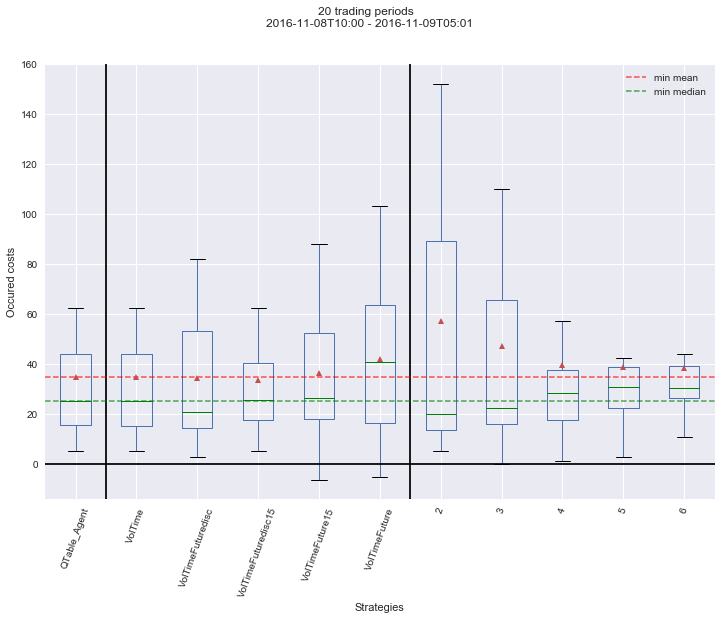

,QTable_Agent,VolTime,VolTimeFuturedisc,VolTimeFuturedisc15,VolTimeFuture15,VolTimeFuture,2,3,4,5,6
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,34.758936,34.738563,34.225688,33.788417,36.481656,42.030169,57.366648,47.203842,39.577751,38.911284,38.498354
std,28.614028,28.658266,30.371154,26.863151,30.352387,31.130289,64.143063,54.722803,47.557648,40.468172,32.738371
min,5.108305,5.108305,2.963437,5.108305,-6.186345,-5.277885,5.108305,-0.045851,1.052188,2.811658,10.676664
25%,15.757211,15.023594,14.307500,17.589332,18.043798,16.429449,13.680122,16.181501,17.494979,22.389074,26.403554
50%,25.108591,25.108591,20.708516,25.480207,26.283760,40.701827,20.090568,22.525473,28.277603,30.904838,30.477179
75%,43.963273,44.035764,53.144765,40.490099,52.587696,63.668509,89.374622,65.573011,37.661238,38.841141,39.048954
max,113.514815,113.514815,121.459484,111.584552,114.206566,103.162993,254.210533,236.953360,221.840571,197.028041,166.060894
rel_mean,1.000000,0.999414,0.984659,0.972079,1.049562,1.209190,1.650414,1.358035,1.138635,1.119461,1.107581
rel_median,1.000000,1.000000,0.824758,1.014800,1.046803,1.621032,0.800147,0.897122,1.126212,1.230847,1.213815


In [62]:
costs_train = None
costs_train = agent_Q.evaluate(
    testdata=data_nov, 
    additional_agents=agent_BatchTree,
    evaluate_actions=range(2,7),
    verbose=False, 
    costs=costs_train,
    show_plot=True,
    baseline=None
)
# agent_Q.plot_evaluation_costs(costs_train, hline='QTable_Agent', showfliers=False)

##### Evaluation: OutSample

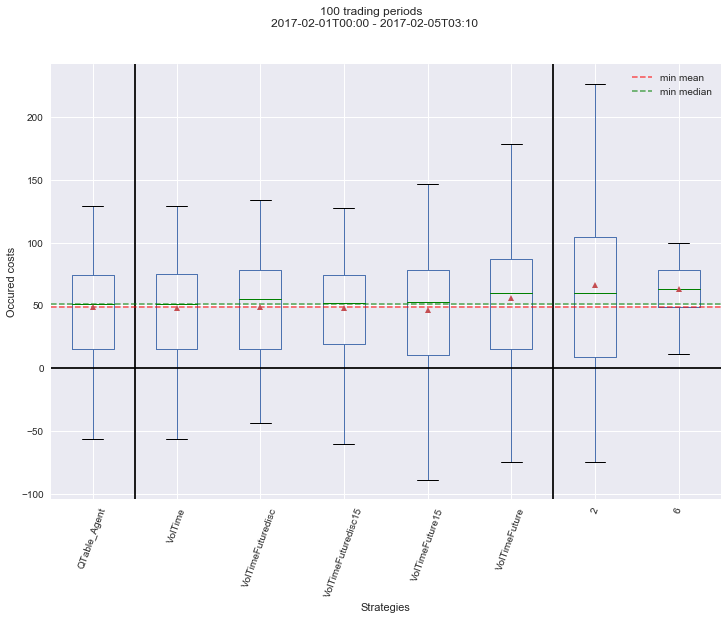

,QTable_Agent,VolTime,VolTimeFuturedisc,VolTimeFuturedisc15,VolTimeFuture15,VolTimeFuture,2,6
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,48.445545,48.199504,48.552989,48.047018,46.723347,56.270366,66.312018,62.930136
std,48.270031,48.088862,48.838879,47.686433,54.328788,79.941065,75.341293,21.292837
min,-74.609426,-74.609426,-85.380958,-74.609426,-88.538122,-169.202163,-74.609426,-6.502580
25%,15.396353,15.385730,14.975995,19.052022,10.676007,15.248859,8.791849,48.427876
50%,50.882121,51.331331,55.337596,51.608187,52.466559,59.725576,59.842563,62.792801
75%,74.515385,74.804482,78.044561,74.590247,78.459838,86.677839,104.880226,78.563403
max,235.484098,235.484098,243.075899,235.325005,227.594565,553.316872,434.487640,100.000204
rel_mean,1.000000,0.994921,1.002218,0.991774,0.964451,1.161518,1.368795,1.298987
rel_median,1.000000,1.008828,1.087565,1.014270,1.031139,1.173803,1.176102,1.234084


In [63]:
costs_test = None
costs_test = agent_Q.evaluate(
    testdata=data_feb[:100],
    additional_agents=agent_BatchTree,
    evaluate_actions=[2, 6],
    verbose=False, 
    costs=costs_test,
    show_plot=True,
    baseline=None
)
# agent_Q.plot_evaluation_costs(costs_test, hline='QTable_Agent', showfliers=False)

In [ ]:
ev = costs_test.describe()

ev.loc['mean_rel',:] = ev.loc['mean',:] / ev.loc['mean','QTable_Agent']
display(ev)

In [ ]:
asks = data_nov[1][0].discretize(depth=4)

In [ ]:
ob = data_nov[1][0]
idx = ob.asks.index
idx

In [ ]:
display(asks.head())
query = [706.05, 706.55, 707.05]

new_df = pd.DataFrame([])
for q in query:
    try:
        idx = asks.index.get_loc(q, method='ffill')
        new_df = pd.concat([new_df, asks.iloc[idx,:]], axis=1)
    except KeyError:
        print("Oops!  That was no valid number.  Try again...")
        row = asks.iloc[0,:].copy()
        display(pd.DataFrame([[0,0,0]], columns=new_df.columns))
        new_df = pd.concat([new_df, pd.DataFrame([[0,0,0]], columns=new_df.columns)], axis=1)
    display(new_df)

In [ ]:
print(data_nov[1][0].asks.head())
idx = data_nov[1][0].asks.index.get_loc(706.187860, method='ffill')
data_nov[1][0].asks.iloc[idx,:]